The purpose of this notebook is to demonstrate analysis conducted on cleaned and normalized data. We will seek to supplement the data found in existing report. Additionally, we will take a brief look at additional analytics that may strengthen analysis/provide impact metrics. 

We will also utilize custom styling methods in hopes of creating a uniform analytical branding style.

For demonstration purposes only.

In [6]:
# Messy imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
from dotenv import load_dotenv
from wordcloud import WordCloud
import os
import sys
import plotly.express as px
import plotly.graph_objects as go
sys.path.append(os.path.join('..', 'utilities'))  # Navigate to utilities folder
from vis_style import apply_plotly_style, apply_matplotlib_style, BMHC_COLORS

In [2]:
# .Env variables and DB Connection
load_dotenv()

user = os.getenv('DB_USER')
password = os.getenv('DB_PASSWORD')
host = os.getenv('DB_HOST')
port = os.getenv('DB_PORT')
db = os.getenv('DB_NAME')

conn_str = f'mssql+pymssql://{user}:{password}@{host}:{port}/{db}' 

engine = create_engine(conn_str)

- All analysis will be conducted primarily on the client satisfaction dataset. Will not require data transformation. Our analysis will be query based and then visualized via python library (plotly for interactive, matplotlib for static)

In [3]:
# Create dataset for visual
query = """
SELECT 
    YEAR(timestamp) as year,
    MONTH(timestamp) as month,
    COUNT(*) as responses
FROM client_satisfaction
GROUP BY YEAR(timestamp), MONTH(timestamp)
ORDER BY year, month
"""

df = pd.read_sql(query, engine)

df['date'] = pd.to_datetime(df[['year', 'month']].assign(day=1))

# Basic interactive bar chart
fig = px.bar(df, 
             x='date', 
             y='responses',
             title='Survey Response by Month',
             labels={'date': 'Month', 'responses': 'Number of Responses'},
             hover_data={'year': True, 'month': True})

# Add mean line
fig.add_hline(y=df['responses'].mean(), 
              line_dash="dash", 
              line_color=BMHC_COLORS['gold'],
              annotation_text=f"2025 Average: {df['responses'].mean():.1f}")

# Customize layout
fig.update_layout(
    xaxis_title='Month',
    yaxis_title='Number of Responses',
    hovermode='x unified',
    height=600,
    showlegend=True
)

# Add text on bars
fig.update_traces(texttemplate='%{y}', textposition='outside')
apply_plotly_style(fig)
fig.show()


cohort-based time series analysis on healthcare visit data using SQL.

Aggregating client visit records by year and month.
Calculating the average number of days between doctor visits for each cohort (month/year).
Preparing metrics to monitor client engagement, visit frequency, and access to care over time.

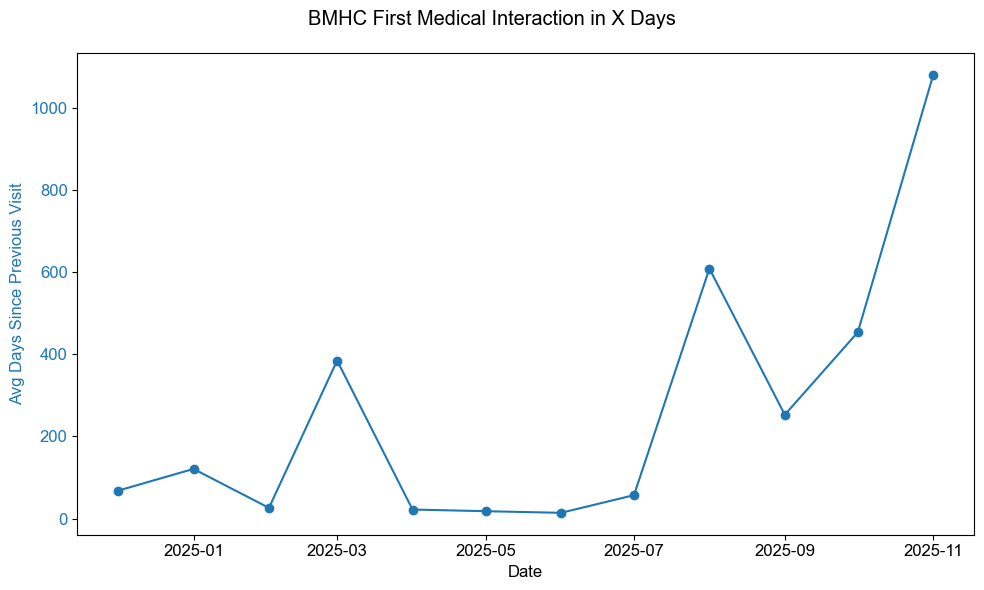

In [16]:
# Create dataset for visual
query = """
WITH total_records AS (
    SELECT COUNT(*) AS total FROM client_satisfaction
),
monthly_counts AS (
    SELECT
        YEAR([timestamp]) AS year,
        MONTH([timestamp]) AS month,
        COUNT(*) AS month_count,
        AVG(DATEDIFF(day, date_previous_doctor_visit, [timestamp])) AS avg_days_since_prev
    FROM client_satisfaction
    GROUP BY YEAR([timestamp]), MONTH([timestamp])
)
SELECT
    m.year,
    m.month,
    m.month_count,
    t.total,
    CAST(m.month_count AS FLOAT) / t.total AS per_capita,
    m.avg_days_since_prev AS "Average span in days since previous doctor visit"
FROM monthly_counts m
CROSS JOIN total_records t
ORDER BY m.year, m.month
"""

df = pd.read_sql(query, engine)

# Date column
df['date'] = pd.to_datetime(df['year'].astype(str) + '-' + df['month'].astype(str) + '-01')

# Matplotlib plotting
apply_matplotlib_style()
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.plot(df['date'], df['Average span in days since previous doctor visit'], color='tab:blue', marker='o', label='Avg Days Since Previous Visit')
ax1.set_xlabel('Date')
ax1.set_ylabel('Avg Days Since Previous Visit', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')


fig.suptitle('BMHC First Medical Interaction in X Days')
fig.tight_layout()
plt.show()


In [12]:
# Create dataset for visual
query = """
SELECT
  health_self_assessment,
  self_health_assessment_narrative,
  stress_self_assessment_narrative,
  mental_self_assessment_narrative,
  physical_self_assessment_narrative
FROM client_satisfaction
WHERE self_health_assessment_narrative IS NOT NULL
"""

df = pd.read_sql(query, engine)
